<a href="https://colab.research.google.com/github/Sajithpemarathna/Energy-Consumption-Data-in-Germany-1995-2020-/blob/main/Annual_Energy_Consumption_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.4677
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.4430
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.4274
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.4016
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.3800
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.3518
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.3210
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2868
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.2565
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2311
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1954
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1747
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1419
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1270
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0870
Epoch 16/100


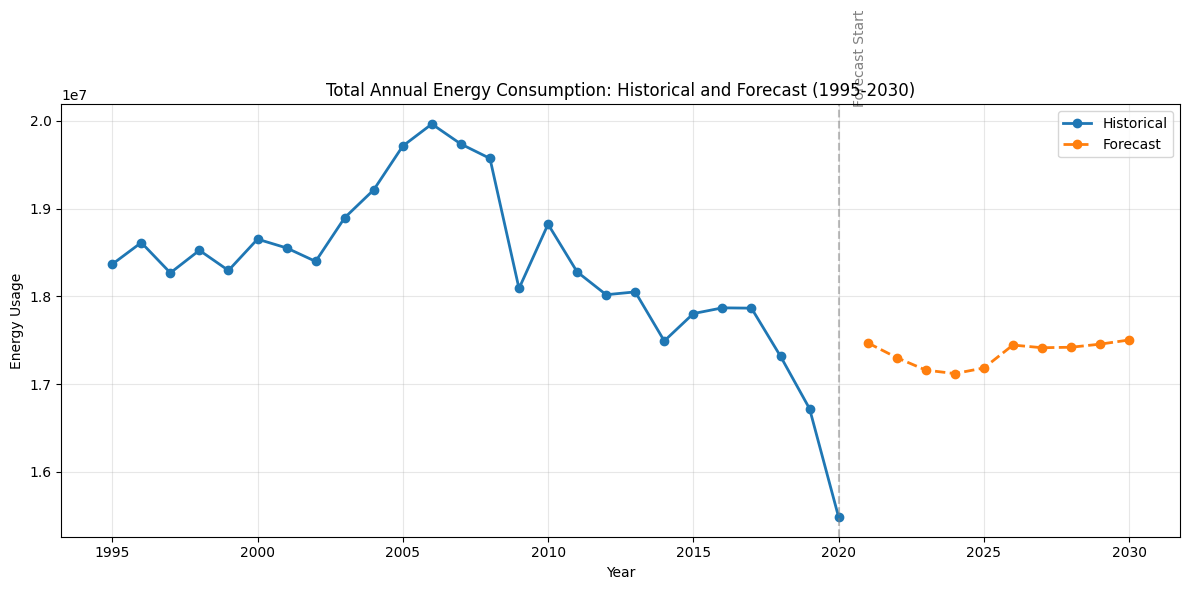


Forecasted values for 2021-2030:
   Year  Energy_Usage
0  2021    17470268.0
1  2022    17301590.0
2  2023    17159170.0
3  2024    17119540.0
4  2025    17183570.0
5  2026    17444714.0
6  2027    17414254.0
7  2028    17419738.0
8  2029    17454930.0
9  2030    17502584.0


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def load_and_process_data(file_path):
    # Load data
    df = pd.read_csv(file_path)
    df_melted = df.melt(id_vars=['Branch Code', 'Homogeneous Branches', 'Energy Carriers'],
                       var_name='Year', value_name='Energy_Usage')
    df_melted['Year'] = pd.to_numeric(df_melted['Year'])

    # Calculate total annual consumption
    annual_consumption = df_melted.groupby('Year')['Energy_Usage'].sum().reset_index()
    return annual_consumption

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def build_model(seq_length):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def forecast_future(model, last_sequence, n_steps, scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_steps):
        next_pred = model.predict(current_sequence.reshape(1, *current_sequence.shape))
        future_predictions.append(next_pred[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred[0]

    return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

def plot_results(historical_data, forecast_data):
    plt.figure(figsize=(12, 6))

    # Plot historical data
    plt.plot(historical_data['Year'], historical_data['Energy_Usage'],
             label='Historical', marker='o', linewidth=2)

    # Plot forecast
    plt.plot(range(2021, 2031), forecast_data,
             label='Forecast', linestyle='--', marker='o', linewidth=2)

    plt.axvline(x=2020, color='gray', linestyle='--', alpha=0.5)
    plt.text(2020.5, plt.ylim()[1], 'Forecast Start', rotation=90, alpha=0.5)

    plt.title('Total Annual Energy Consumption: Historical and Forecast (1995-2030)')
    plt.xlabel('Year')
    plt.ylabel('Energy Usage')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def main():
    # Load data
    file_path = "https://raw.githubusercontent.com/Sajithpemarathna/Energy-Consumption-Data-in-Germany-1995-2020-/refs/heads/main/Use%20of%20Energy%20of%20Energy%20Carriers.csv"
    data = load_and_process_data(file_path)

    # Scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data['Energy_Usage'].values.reshape(-1, 1))

    # Create sequences
    seq_length = 5
    X, y = create_sequences(scaled_data, seq_length)

    # Train model
    model = build_model(seq_length)
    model.fit(X, y, epochs=100, batch_size=32, verbose=1)

    # Generate forecasts
    last_sequence = scaled_data[-seq_length:]
    forecast = forecast_future(model, last_sequence, 10, scaler)

    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'Year': range(2021, 2031),
        'Energy_Usage': forecast.flatten()
    })

    # Plot results
    plot_results(data, forecast)

    # Export results
    combined_data = pd.concat([data, forecast_df])
    combined_data.to_excel('annual_energy_consumption_forecast_1995_2030.xlsx', index=False)
    print("\nForecasted values for 2021-2030:")
    print(forecast_df)

if __name__ == "__main__":
    main()